In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections, transforms
import os
import re
import matplotlib.tri as tri
from tqdm.notebook import tqdm
from tqdm import notebook
import time
from scipy.spatial import cKDTree

Импорт и обработка КЭ сетки

In [2]:
# file re-paths markers
mark_start  = re.compile(r"\(2\s(?P<DIMEN>2|3)\)")
mark_nodes  = re.compile(r"\(10\s\((\d)\s([a-zA-Z0-9]+)\s([a-zA-Z0-9]+)\s([a-zA-Z0-9]+)\s([a-zA-Z0-9]+)\)\(")
mark_nodes_icem  =re.compile(r"\(10\s\(([a-zA-Z0-9]+)\s([a-zA-Z0-9]+)\s([a-zA-Z0-9]+)\s([a-zA-Z0-9]+)\s([a-zA-Z0-9]+)")
mark_faces  =     re.compile(r"\(13\s\(([a-zA-Z0-9]+)\s([a-zA-Z0-9]+)\s([a-zA-Z0-9]+)\s([a-zA-Z0-9]+)\s([a-zA-Z0-9]+)\)\(")
mark_ends   = re.compile(r"\)\)")
mark_ends_icem   = re.compile(r"\)")

imported mesh file

In [3]:
filename = "mesh/mesh_file.msh"                      # Single Cylinde rMesh

In [4]:
# Читается файл с сеткой в качестве выходных данных
# facename2properties - номер области, тип условий, название
# nodes_list  - сквозной список координат узлов 
# node_index  - индексы областей с узлами
# node2zone   - номера узлов в областях node_index
# inter_faces - сквозной список граней  n0 n1 n2 cr cl, если  cl = 0 то эта грань внешняя
# zone_index  - индекс областей всех подряд
# faces2zone -  номера граней в областях zone_index
facename2properties = []
nodes_list = []
#node_index = [] - вроде не особо нужно
node2zone = []
inter_faces = []
zone_index = []
faces2zone = []
with open (filename, "r") as f:
    # read upto the dimension section and check dimension of the task
    for line in f:
        if re.search(mark_start, line):
            dimension = re.search(r"\(2\s(?P<DIMEN>2|3)\)", line)['DIMEN']
            print('Размерность сетки:', dimension)
            if dimension != '2':
                print('Обработка для 3D сетки еще не выполнена')
                exit()
            break
    # continue read the file
    for line in f:
        # search for node data and aggregate full list of node X , Y , Z(not now) - ICEM type mesh !!!!
        if re.search(mark_nodes_icem, line) and line[-3] != ')':           # last symbol is space  ???
            obj = line[5:-2].split()
#            node_index.append(int(obj[0], 16))
            n1 = int(obj[1], 16)
            nn = int(obj[2], 16)
            node2zone.append([n1, nn])
            nodes_list = np.zeros([nn-n1+1,2])
            line = f.readline()
            line = f.readline()
            k = 0
            while line[-2] != ')':
                extracted = [float(s) for s in line.split()]
                nodes_list [k, :] = extracted
                k += 1
                line = f.readline()
        if re.findall(mark_faces, line):
            obj = line[5:-3].split()
            zone_index.append(int(obj[0], 16))
            n1 = int(obj[1], 16)
            nn = int(obj[2], 16)
            faces2zone.append([n1, nn])
            line = f.readline()
            while line[-2] != ')':
                extracted = [int(s, 16) for s in line.split()]
                inter_faces.append(extracted)
                line = f.readline()
        if re.findall(r"45|39", line):
            obj = line[5:-5].split()
            facename2properties.append(obj)
inter_faces = np.array(inter_faces)

Размерность сетки: 2


In [5]:
print(facename2properties)
print(nodes_list.shape)
print(len(inter_faces))
print(node2zone)
print(zone_index)
print(faces2zone)

[['12', 'fluid', 'SOLID-SURFACE'], ['13', 'interior', 'int_SOLID-SURFACE'], ['14', 'velocity-inlet', 'INLET'], ['15', 'wall', 'TOP'], ['16', 'wall', 'BOTTOM'], ['17', 'wall', 'WALL'], ['18', 'pressure-outlet', 'OUTLET']]
(1425, 2)
2759
[[1, 1425]]
[13, 14, 15, 16, 17, 18]
[[1, 2577], [2578, 2592], [2593, 2637], [2638, 2682], [2683, 2743], [2744, 2759]]


__Формирование матрицы el2face = [el f1 f2 f3 f4] и el2node = [el n1 n2 n3 n4]__

In [6]:
inter_faces_inline = np.array(inter_faces)
inter_faces_inline = np.vstack((inter_faces_inline[:, 0:3], inter_faces_inline[:, [0, 1, 3]]))
inter_faces_inline = inter_faces_inline[inter_faces_inline[:,2]>0]

In [7]:
ne = max(inter_faces_inline[:,2])
el2nodes = np.zeros([ne, 8])
for i in notebook.tqdm(            range(0, len(inter_faces_inline))           ):
    iel = inter_faces_inline[i,2] - 1                                                     #  потому что элементы с 1, а индексы с 0
    zero_index = np.argmax(el2nodes[iel,:] == 0)
    el2nodes[iel, zero_index:zero_index+2] = inter_faces_inline[i,0:2]

  0%|          | 0/5336 [00:00<?, ?it/s]

In [8]:
el_list = np.zeros([len(el2nodes), 4]).astype(int)
for i in notebook.tqdm(range (0,len(el_list))):
    el_list[i,:] = np.unique(el2nodes[i, 1:]) 

  0%|          | 0/1334 [00:00<?, ?it/s]

In [9]:
ne = len(el_list)
nf = len(inter_faces)
nn = len(nodes_list)

In [10]:
## Сортировка порядка узлов для 4х узловых элементов, для отображения
for i in notebook.tqdm(range(ne)):
    if el_list[i,-1] != -1:
        indX = el_list[i,:] - 1                           #  потому что элементы с 1, а индексы с 0
        cx = nodes_list[indX, 0].mean()
        cy = nodes_list[indX, 1].mean()
        x = nodes_list[indX, 0]
        y = nodes_list[indX, 1]
        angles = np.arctan2(x-cx, y-cy)
        indices = np.argsort(-angles)
        el_list[i,:] = el_list[i,indices] 

  0%|          | 0/1334 [00:00<?, ?it/s]

In [11]:
# определение характеристик элементов
# el_quantities[i, 0] - Xel проекция координаты центра тяжести элемента на ось X
# el_quantities[i, 1] - Yel проекция координаты центра тяжести элемента на ось Y
# el_quantities[i, 2] - площадь элемента (Shoelace formula)
el_quantities = np.zeros((ne, 3))
for i in notebook.tqdm (range (ne)):
    indX = el_list[i,:] -1                                #  потому что элементы с 1, а индексы с 0
    if indX[-1] == -1:
        quant = 3
    else:
        quant = 4
    x = nodes_list[indX, 0]
    y = nodes_list[indX, 1]
    SXC, SYC  = 0, 0
    element_area = 0
    for t in range (quant):
        xi0, xi1 = x[t] , x[(t + 1) % quant]
        yi0, yi1 = y[t] , y[(t + 1) % quant]
        area = (xi0 * yi1) - (xi1 * yi0)
        SXC += (xi0 + xi1) * area
        SYC += (yi0 + yi1) * area
        element_area += 0.5* area
    SXC /= 6 * element_area
    SYC /= 6 * element_area
    el_quantities[i, 0] = SXC
    el_quantities[i, 1] = SYC
    el_quantities[i, 2] = element_area

  0%|          | 0/1334 [00:00<?, ?it/s]

In [12]:
# определение характеристик граней
# face_quantities[i,0:2]     - CF вектор
# face_quantities[i,2]       - length of CF
# face_quantities[i,3:5]     - ecf                 
# face_quantities[i,5:7]     - Sf1 - n to line    
# face_quantities[i,7]       - length of Sf1
# face_quantities[i,8:10]    - esf                   
# face_quantities[i,10:12]   - rf - rf'  вектор                  
# face_quantities[i,12]      - gs'                
# face_quantities[i,13:15]   - Ef1       вектор
# face_quantities[i,15:17]   - Tf1       вектор
# face_quantities[i,17]      - Tf1  length of Tf1

face_quantities = np.full((nf,20), fill_value = -1, dtype = float)

# берем первые две name zone и последний индекс грани - будет ли работать на других сетках больой вопрос надо проверять + проверка если гу зоны не объявлены
inner_faces = np.max(faces2zone[0:1])          #np.max(faces2zone[0:2]) if len(facename2index)>3 else np.max(faces2zone[0:1])           

# для внутренних граней
for i in notebook.tqdm( range(inner_faces)):
    indX = inter_faces[i, :] - 1
    rf = 0.5*(nodes_list[indX[1]] + nodes_list[indX[0]]) 
    Sf = np.array([nodes_list[indX[1], 1] - nodes_list[indX[0], 1], -(nodes_list[indX[1], 0] - nodes_list[indX[0], 0])]) # нормаль не нормирована - модуль это длина линии
    rC = el_quantities[indX[2], 0:2]
    rF = el_quantities[indX[3], 0:2]
    dCF = rF - rC                                                                                  # CF - vector из конца в начало 
    face_quantities[i,0:2]   = dCF                                                                 # CF
    face_quantities[i,2]     = np.linalg.norm(dCF)                                                 # CF                  length of CF 
    face_quantities[i,5:7]   = (np.sign(np.dot(dCF, Sf)) + (np.dot(dCF, Sf) == 0))*Sf              # Sf1 - n to line
    rf_ = rC + np.dot(rf - rC, dCF)/np.dot(dCF, dCF)*(dCF)                                         # rf'
    face_quantities[i,10:12] = rf - rf_                                                            # rf - rf' 
    face_quantities[i,12]    = np.linalg.norm(rF - rf_)/face_quantities[i,2]                       # gs'                 
    face_quantities[i,18:20] = rf                                                                                        #  rf
# для внешних граней
for i in notebook.tqdm (range(inner_faces, nf)):
    indX = inter_faces[i, :] - 1
    rb = 0.5*(nodes_list[indX[1]] + nodes_list[indX[0]])
    Sf  = np.array([nodes_list[indX[1], 1] - nodes_list[indX[0], 1], -(nodes_list[indX[1], 0] - nodes_list[indX[0], 0])])  # нормаль не нормирована - модуль это длина линии 
    rC = el_quantities[indX[2], 0:2]
    dCb = rb - rC  
    face_quantities[i,0:2]   = dCb                                                                   # Cb                  
    face_quantities[i,2]     = np.linalg.norm(dCb)                                                   # Cb                  length of Cb           
    face_quantities[i,5:7]   = (np.sign(np.dot(dCF, Sf)) + (np.dot(dCF, Sf) == 0))*Sf                # Sb1 - n to line           
    face_quantities[i,10:12] = [0, 0]                                                                # rf - rf'            ! исправлено          
    face_quantities[i,12]    = 0                                                                     # gs'                 ! исправлено
    face_quantities[i,18:20] = rb

face_quantities[:,3:5]   = face_quantities[:,0:2]/face_quantities[:,2, np.newaxis]                                                         # ecb 
face_quantities[:,7]     = np.linalg.norm(face_quantities[:,5:7])                                                                          # Sb1 - n to line     length of Sf1
face_quantities[:,8:10]  = face_quantities[:,5:7]/face_quantities[:,7, np.newaxis]                                                         # esf 
face_quantities[:,13:15] =  np.einsum('ij,ij->i', face_quantities[:,3:5], face_quantities[:,5:7])[:, np.newaxis]*face_quantities[:,3:5]    #  Ef1 хз как это работает
face_quantities[:,15:17] = face_quantities[:,5:7] - face_quantities[:,13:15]                                                               #  Tf1
face_quantities[:,17] =  np.linalg.norm(face_quantities[:,13:15])                                                                          #  Ef1  length of Ef1

  0%|          | 0/2577 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

импорт сетки из файла результата

In [13]:
# Для демонстрации сетки
def plot_fem_mesh(nodes_xy, elements, xlim, ylim):
    xmin, xmax = xlim
    ymin, ymax = ylim
    for i, element in notebook.tqdm(enumerate(elements)):
        if (xmin < el_quantities[i, 0]< xmax) & (ymin < el_quantities[i, 1]< ymax):
            plt.plot(nodes_xy[element[:] - 1, 0], nodes_xy[element[:] - 1, 1], 'ko-', markersize=0.1)

0it [00:00, ?it/s]

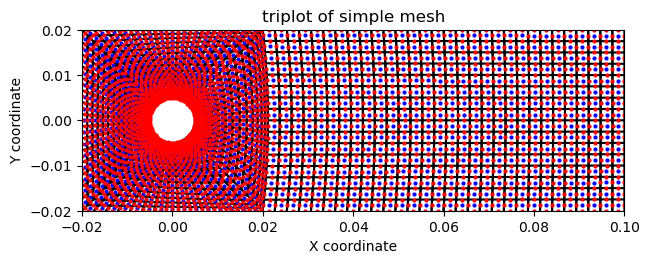

In [14]:
# Демонстрация сетки с нормалями для проверки
fig2, ax2 = plt.subplots(figsize=(7,7))
ax2.set_aspect('equal')
xlim = [-0.02, 0.1]
ylim = [-0.02, 0.02]
plot_fem_mesh(nodes_list, el_list,  xlim, ylim)
ax2.plot(el_quantities[:, 0], el_quantities[:, 1],     'bo',  markersize=2)               # centers of elements
ax2.plot(face_quantities[:,18], face_quantities[:,19], 'ro',  markersize=2)               # middle of face
ax2.set_xlim(xlim)   # set the xlim to left, right
ax2.set_ylim(ylim)   # set the xlim to left, right
ax2.set_title('triplot of simple mesh')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
plt.show()